In [79]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go

### Descargar el modelo pre-entrenado de BERT en Español

In [80]:
# English:
# MODEL = 'bert-base-uncased'

# Spanish:
MODEL = "dccuchile/bert-base-spanish-wwm-uncased"

In [81]:
# Load pre-trained BERT model and tokenizer
#tokenizer = BertTokenizer.from_pretrained(MODEL)
#model = BertForMaskedLM.from_pretrained(MODEL)

# Los anteriores son ejemplos de BERT preentrenado en inglés, para usar el modelo en español usa:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForMaskedLM.from_pretrained(MODEL)

### 1. Ejemplo de uso de BERT para imputación de texto

In [82]:
# Ejemplo de oraciones con espacios en blanco
sentences = ["ella es una [MASK] en el hospital", "El es un [MASK] en el hospital"]

# Vamos a tokenizar las oraciones
tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]
# Obtenemos el ID del token [MASK]
masked_token_id = tokenizer.convert_tokens_to_ids('[MASK]')

# En cada oracion obtenemos los indices de los tokens [MASK]
masked_indices = []
for sentence in tokenized_sentences:
    masked_indices.append([i for i, token in enumerate(sentence) if token == masked_token_id])

# Convertir los token ids a tensores de torch
input_tensors = [torch.tensor([input_ids]) for input_ids in tokenized_sentences]

In [83]:
# Usamos el modelo para predecir el token [MASK]
with torch.no_grad():
    predictions = [model(input_tensor).logits.squeeze(0) for input_tensor in input_tensors]

In [84]:
# Obtenemos las predicciones para cada oracion
def get_prediction(i, masked_indices, predictions, sentence, n=5):
    """ Para obtener la predicción de una oración necesitamos:
    - El índice de la oración
    - Los índices de los tokens [MASK] en la oración
    - Las predicciones del modelo para la oración
    - La oración tokenizada
    
    Retornamos:
    - La oración con los tokens [MASK] reemplazados por las predicciones del modelo
    """
    for masked_index in masked_indices[i]:
        predicted_token_probs = predictions[i][masked_index]
        top_n_predictions = torch.topk(predicted_token_probs, n)
        # Convertir los token ids a palabras
        top_prediction_words = [tokenizer.decode(token_id.item()) for token_id in top_n_predictions.indices]

        # Plot the top n predictions
        plt.bar(range(n), top_n_predictions.values.tolist())
        plt.xlabel(f'Top {n} Predicciones')
        plt.ylabel('Probabilidad')
        plt.title(f'Top {n} Predicciones para la palabra en índica {masked_index}')
        plt.xticks(range(n), top_prediction_words, rotation='vertical')
        plt.show()

        predicted_token_id = torch.argmax(predictions[i][masked_index]).item()
        sentence[masked_index] = predicted_token_id

    return sentence

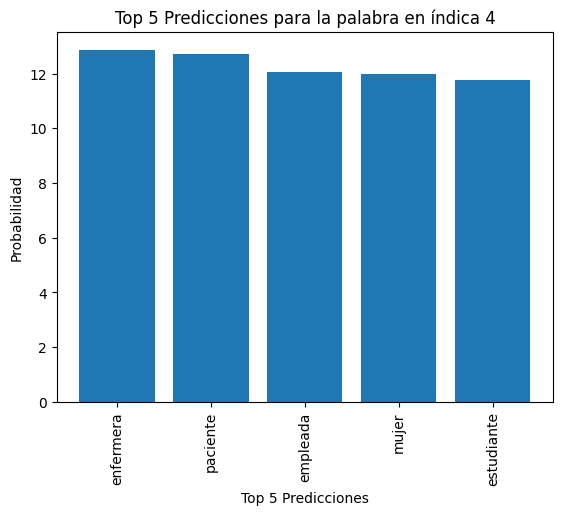

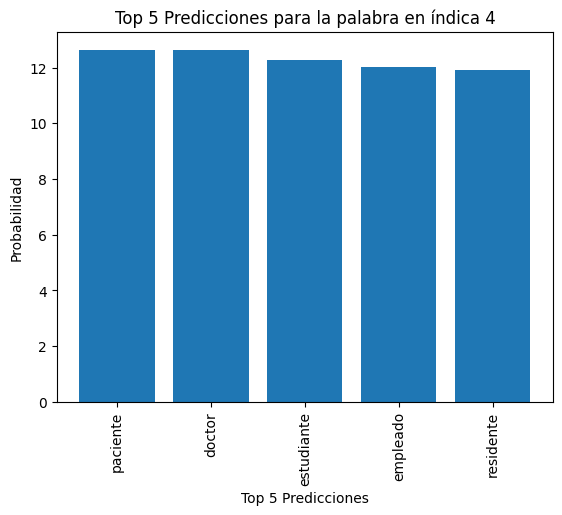

Original sentence: ['ella es una [MASK] en el hospital', 'El es un [MASK] en el hospital']
Imputed sentence: ['ella es una enfermera en el hospital', 'el es un paciente en el hospital']


In [85]:
# Reemplazar los tokens [MASK] por las predicciones del modelo usando la función get_prediction
imputed_sentences = [get_prediction(i, masked_indices, predictions, sentence) for i, sentence in enumerate(tokenized_sentences)]

# Reconstruir las oraciones usando el tokenizer
imputed_sentences = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(imputed_sentence, skip_special_tokens=True)) for imputed_sentence in imputed_sentences]

print("Original sentence:", sentences)
print("Imputed sentence:", imputed_sentences)

### 2. UI Example:

In [86]:
import gradio as gr
import plotly.graph_objects as go
# Obtenemos las predicciones para cada oracion
def get_prediction(i, masked_indices, predictions, sentence):
    for masked_index in masked_indices[i]:
        predicted_token_id = torch.argmax(predictions[i][masked_index]).item()
        sentence[masked_index] = predicted_token_id

    return sentence

def password(password):
    return password == 'burpee'

# Reemplazar los tokens [MASK] por las predicciones del modelo usando la función get_prediction
def complete_sentence(sentences):

    sentences = sentences.split("\n")

    # Tokenizar las oraciones
    if isinstance(sentences, str):
        sentences = [sentences]

    # Obtenemos el ID del token [MASK]
    tokenized_sentences = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in sentences]
    masked_token_id = tokenizer.convert_tokens_to_ids('[MASK]')

    # Obtenemos la posición de los tokens [MASK] en cada oración
    masked_indices = []
    for sentence in tokenized_sentences:
        masked_indices.append([i for i, token in enumerate(sentence) if token == masked_token_id])

    # convertir los token ids a tensores de torch
    input_tensors = [torch.tensor([input_ids]) for input_ids in tokenized_sentences]

    # Predecir los valores en la posición de los tokens [MASK]
    with torch.no_grad():
        predictions = [model(input_tensor).logits.squeeze(0) for input_tensor in input_tensors]

    # Reemplazar los tokens [MASK] por las predicciones del modelo usando la función get_prediction
    imputed_sentences = [get_prediction(i, masked_indices, predictions, sentence) for i, sentence in enumerate(tokenized_sentences)]
    # Agregar un símbolo '+' para indicar que el token fue imputado
    imputed_sentences_tekens = [[(token, '+' if token == masked_token_id else None) for token in sentence] for sentence in imputed_sentences]

    # Reconstruir las oraciones usando el tokenizer
    imputed_sentences = [tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(imputed_sentence, skip_special_tokens=True)) for imputed_sentence in imputed_sentences]

    return sentences, imputed_sentences

def display_imputed_sentences(sentences):
    # Obtener las oraciones originales y las imputadas
    original_sentences, imputed_sentences = complete_sentence(sentences)

    display_sentences = []
    for sentence, imputed_sentence in zip(original_sentences, imputed_sentences):

        sentence = sentence.split()
        imputed_sentence = imputed_sentence.split()

        for index in range(len(sentence)):
            word = sentence[index]
            imputed_word = imputed_sentence[index]
            if word == '[MASK]':
                display_sentences.append((imputed_word, '+'))
            else:
                display_sentences.append((word, None))
            display_sentences.append((' ', None))

        display_sentences.append(('\n', '-'))

    display_sentences = ''.join([word for word, _ in display_sentences])

    return display_sentences


with gr.Blocks() as demo:

    # Definir el input component
    input_text = gr.Textbox(lines=3, 
                            label="Ingrese una oración por línea. Los valores marcados deben representarse como [MASK]", 
                            value="ella es una [MASK] en el hospital\n El es un [MASK] en el hospital")


    # Definir el botón
    btn = gr.Button(value="Completar el texto")

    # Definir el output component
    out = gr.Textbox()

    # Si el botón es presionado, ejecutar la función display_imputed_sentences
    btn.click(display_imputed_sentences, inputs=[input_text], outputs=[out])

    # Cargamos la interfaz
    demo.load(display_imputed_sentences, inputs=[input_text], outputs=[out])

    # Ejecutamos la interfaz
    demo.launch()
    #demo.launch(auth=password)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
